In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-dark')
warnings.filterwarnings('ignore')

# Read and Clean Data

In [36]:
PATH = 'drive/My Drive/Data/'
data_file = 'investments_VC.csv'
columns_to_drop = ['permalink','name','homepage_url','category_list','state_code',
                  'region','founded_at','founded_month','founded_quarter']

def read_data(path, datafile, columns_to_drop):
  df = pd.read_csv(PATH + datafile, encoding = 'ISO-8859-1')
  df = df.drop(columns = columns_to_drop)
  new_col = df.columns.str.replace(' ','')
  df_new = df.rename(columns = dict(zip(df.columns[0:], new_col)))
  df_new = df_new.dropna(how = 'all')

  return df_new


data = read_data(path = PATH, datafile = data_file, columns_to_drop = columns_to_drop)

In [37]:
data.head()

,market,funding_total_usd,status,country_code,city,funding_rounds,founded_year,first_funding_at,last_funding_at,seed,venture,equity_crowdfunding,undisclosed,convertible_note,debt_financing,angel,grant,private_equity,post_ipo_equity,post_ipo_debt,secondary_market,product_crowdfunding,round_A,round_B,round_C,round_D,round_E,round_F,round_G,round_H
0,News,"17,50,000",acquired,USA,New York,1.0,2012.0,2012-06-30,2012-06-30,1750000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Games,"40,00,000",operating,USA,Los Angeles,2.0,NaN,2010-06-04,2010-09-23,0.0,4000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Publishing,"40,000",operating,EST,Tallinn,1.0,2012.0,2012-08-09,2012-08-09,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Electronics,"15,00,000",operating,GBR,London,1.0,2011.0,2011-04-01,2011-04-01,1500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Tourism,"60,000",operating,USA,Fort Worth,2.0,2014.0,2014-08-17,2014-09-26,0.0,0.0,60000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
data.shape

(49438, 30)

In [12]:
# funding_col = 'funding_total_usd'
# groupby_col = 'market'

# def convert_funding_amount(df, col, group_col):
#   df[col] = df[col].str.replace(' ','')
#   # split dataframe
#   temp1 = df[df[col] == '-']
#   temp2 = df[df[col] != '-']
#   # replace
#   temp1[col] = temp1[col].apply(lambda x: x.replace('-', '0'))
#   temp2[col] = temp2[col].apply(lambda x: x.replace(',', ''))
#   # combine 
#   combined = pd.concat([temp1, temp2])
#   df_new = combined.sort_index()
#   # convert to float and replace 0
#   df_new[col] = df_new[col].astype(float)
#   df_new[col] = df_new[col].replace(0, np.nan)
#   # fill na with average funding amout by market
#   df_new[col] = df_new[col].fillna(df_new.groupby(group_col)[col].transform('mean'))

#   return df_new

# data = convert_funding_amount(df = data, col = funding_col, group_col = groupby_col)

In [13]:
# cat_var = data.select_dtypes(include = ['object']).columns
# num_var = data.select_dtypes(include = ['float64']).columns
# print(cat_var)
# print(num_var)

# Feature Selection


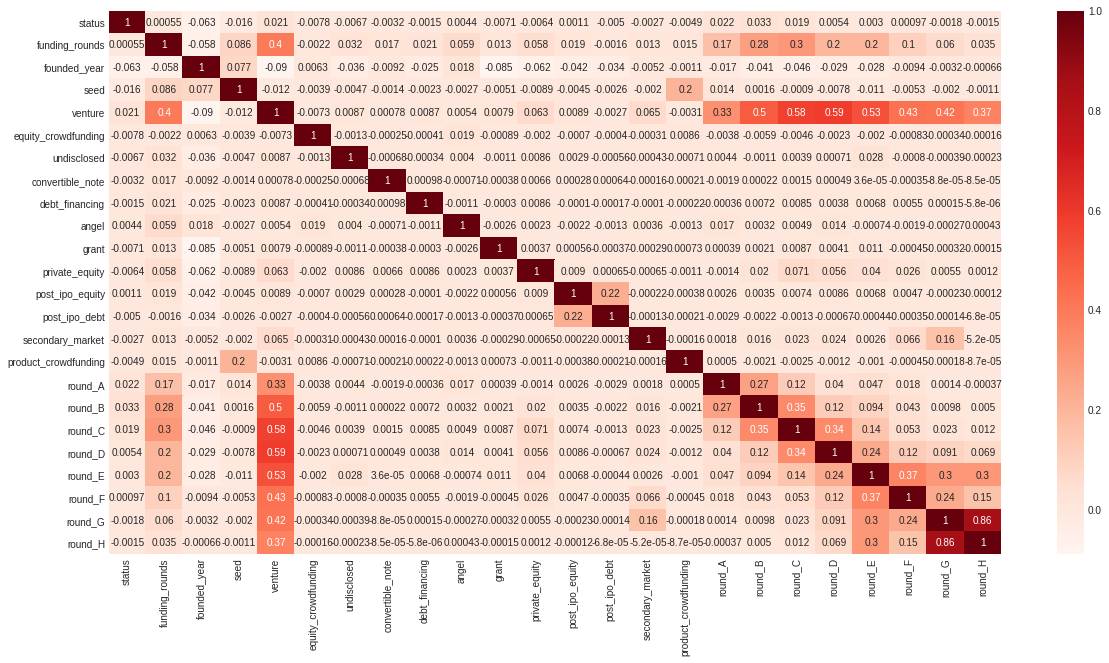

In [39]:
# feature selection using correlation

def encode_target(data):
  X = data.copy()
  X = X.replace('NaN', np.nan)
  X = X.fillna('missing')
  X = X.map({'missing': 0, 'operating': 1, 'acquired': 2, 'closed': 3})
  return X  

data['status'] = encode_target(data['status'])
plt.figure(figsize = (20,10))
corr = data.corr()
sns.heatmap(corr, annot = True, cmap = plt.cm.Reds) 

In [40]:
# feature selection based on correlation
corr_target = abs(corr['status'])
relevant_features = corr_target[corr_target >0.005]
relevant_features

status                 1.000000
founded_year           0.063034
seed                   0.016135
venture                0.021453
equity_crowdfunding    0.007821
undisclosed            0.006659
grant                  0.007110
private_equity         0.006398
post_ipo_debt          0.005009
round_A                0.021617
round_B                0.033379
round_C                0.018645
round_D                0.005437
Name: status, dtype: float64

In [41]:
relevant_features.index

Index(['status', 'founded_year', 'seed', 'venture', 'equity_crowdfunding',
       'undisclosed', 'grant', 'private_equity', 'post_ipo_debt', 'round_A',
       'round_B', 'round_C', 'round_D'],
      dtype='object')

In [42]:
data = data[relevant_features.index]
data.head()

,status,founded_year,seed,venture,equity_crowdfunding,undisclosed,grant,private_equity,post_ipo_debt,round_A,round_B,round_C,round_D
0,2,2012.0,1750000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,NaN,0.0,4000000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,2012.0,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,2011.0,1500000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,2014.0,0.0,0.0,60000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
data['status'].value_counts()

1    41829
2     3692
3     2603
0     1314
Name: status, dtype: int64

In [44]:
# train test split
from sklearn.model_selection import train_test_split
features = data.drop(columns = 'status')
target = data['status']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 42)

# Feature Engineering

In [45]:
def fill_na(df):
  for col in df:
    if df[col].dtypes == 'O':
      df[col] = df[col].replace('NaN',np.nan)
      df[col] = df[col].fillna('missing')
    else:
      df[col] = df[col].fillna(0)
  return df

X_train = fill_na(X_train)
X_test = fill_na(X_test)

In [46]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(34606, 12) (34606,)
(14832, 12) (14832,)


In [48]:
cat_var = X_train.select_dtypes(include = ['object']).columns
num_var = X_train.select_dtypes(include = ['float64']).columns
print(cat_var)
print(num_var)

Index([], dtype='object')
Index(['founded_year', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed',
       'grant', 'private_equity', 'post_ipo_debt', 'round_A', 'round_B',
       'round_C', 'round_D'],
      dtype='object')


In [65]:
# rebalancing target data
from imblearn.combine import SMOTETomek

def rebalance_target(X,y, method):
  smt = method
  X, y = smt.fit_sample(X,y)
  return X,y

X_train, y_train = rebalance_target(X_train, y_train, SMOTETomek(ratio = 'auto'))
print(X_train.shape, y_train.shape)

(102136, 12) (102136,)


In [67]:
unique, counts = np.unique(y_train, return_counts = True)
print(np.asarray((unique, counts)).T)

[[    0 25502]
 [    1 25823]
 [    2 25426]
 [    3 25385]]


In [78]:
import imblearn

imblearn.__version__

'0.4.3'

In [68]:
from sklearn.preprocessing import MinMaxScaler


# cat_columns = ['market', 'country_code', 'city', 'first_funding_at','last_funding_at']
# num_columns = ['funding_total_usd', 'funding_rounds', 'founded_year', 'seed',
#                 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note',
#                 'debt_financing', 'angel', 'grant', 'private_equity', 'post_ipo_equity',
#                 'post_ipo_debt', 'secondary_market', 'product_crowdfunding', 'round_A',
#                 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G',
#                 'round_H']

num_columns = ['founded_year', 'seed', 'venture', 'equity_crowdfunding', 'undisclosed',
              'grant', 'private_equity', 'post_ipo_debt', 'round_A', 'round_B',
              'round_C', 'round_D']

# def encode_cat_features(df,cols):
#   df = pd.get_dummies(df, drop_first = True, columns = cols )
#   return df

def scale_features(df, scaler):
  sc = scaler
  feature_sc = sc.fit_transform(df)
  return feature_sc

# X_train_enc = encode_cat_features(X_train, cat_columns)
X_train_enc = scale_features(X_train, MinMaxScaler())
# X_test_enc = encode_cat_features(X_test, cat_columns)
X_test_enc = scale_features(X_test, MinMaxScaler())


print(X_train_enc.shape, X_test_enc.shape)

(102136, 12) (14832, 12)


In [69]:
# def dim_reduction(df, method):
#   pca = method
#   feature_rdim = pca.fit_transform(df)
#   return feature_rdim


# pca = PCA(n_components = 200)
# X_train_rdim = pca.fit_transform(X_train_enc)

In [29]:
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.decomposition import PCA

# # split feature and target
# cat_columns = ['market', 'status', 'country_code', 'city', 'first_funding_at','last_funding_at']
# num_columns = ['funding_total_usd', 'funding_rounds', 'founded_year', 'seed',
#                 'venture', 'equity_crowdfunding', 'undisclosed', 'convertible_note',
#                 'debt_financing', 'angel', 'grant', 'private_equity', 'post_ipo_equity',
#                 'post_ipo_debt', 'secondary_market', 'product_crowdfunding', 'round_A',
#                 'round_B', 'round_C', 'round_D', 'round_E', 'round_F', 'round_G',
#                 'round_H']

# features = data.drop(columns = ['status'])
# target = 'status'

# def encode_target(df, target):
#   df[target] = df[target].map({'missing': 0, 'operating': 1, 'acquired': 2, 'closed':3})
#   return df[target]

# def encode_cat_features(df,cols):
#   df = pd.get_dummies(df, drop_first = True, columns = cols )
#   return df

# def scale_features(df, scaler):
#   sc = scaler
#   feature_sc = sc.fit_transform(df)
#   return feature_sc

# def dim_reduction(df, cols, method):
#   pca = method
#   feature_rdim = pca.fit_transform(df[cols])
#   return feature_rdim


# x = data.copy()
# target = encode_target(x, target)
# features = encode_cat_features(x, cat_columns)
# # feature_sc = scale_features(features, MinMaxScaler())


# Building Model

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# # train test split
# X_train,  X_test, y_train, y_test = train_test_split(features, target, test_size = 0.3, random_state = 42)

# create class object
class stacked_model(BaseEstimator, ClassifierMixin):
    def __init__(self, base_models = None, meta_model = None, n_folds = None):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    def fit(self,X,y):
        level0 = []
        for name, model in self.base_models:
            level0.append((name, model))
        level1 = self.meta_model
        self.get_stacking_ = StackingClassifier(estimators = self.base_models, final_estimator = level1, cv = self.n_folds)
        self.get_stacking_.fit(X,y)
        
        return self
    
    def predict(self, X):
        y_pred = self.get_stacking_.predict(X)
        return y_pred

base_model = [('XGB', XGBClassifier(n_estimators = 150, objective = 'multi:softmax', num_class = 4)), ('lgb', LGBMClassifier(n_estimators = 150, objective = 'multiclass'))]
meta_model = LogisticRegression()

stack_pipeline = Pipeline([('model', stacked_model(base_models = base_model, meta_model = meta_model, n_folds = 3))])

stack_pipeline.fit(X_train, y_train)
y_pred = stack_pipeline.predict(X_test.values)
acc = accuracy_score(y_test, y_pred)
print(acc)
print(classification_report(y_test, y_pred))                                                       

0.6109088457389428
              precision    recall  f1-score   support

           0       0.06      0.27      0.10       386
           1       0.88      0.67      0.76     12617
           2       0.21      0.27      0.24      1076
           3       0.11      0.31      0.16       753

    accuracy                           0.61     14832
   macro avg       0.32      0.38      0.32     14832
weighted avg       0.77      0.61      0.68     14832



In [87]:
confusion_matrix(y_test, y_pred)

array([[ 106,  207,   36,   37],
       [1503, 8425,  986, 1703],
       [ 100,  530,  295,  151],
       [  68,  375,   75,  235]])

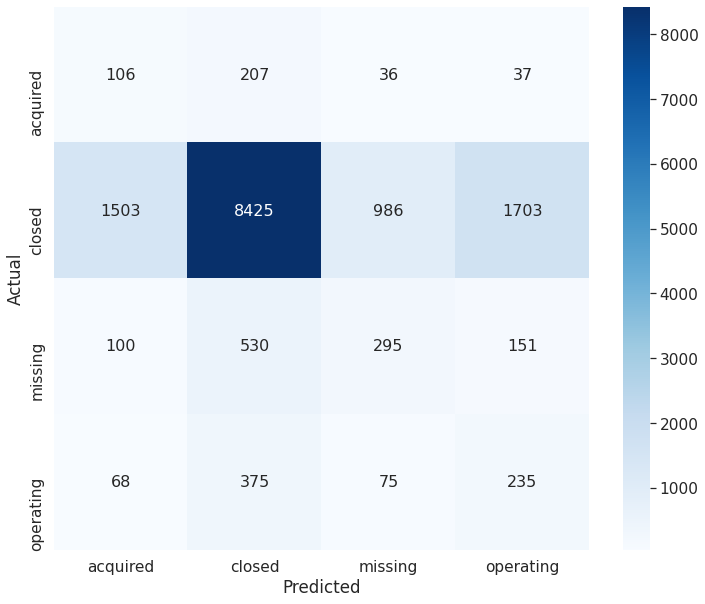

In [89]:
# confusion matrix
from sklearn.metrics import confusion_matrix
sns.set_style('darkgrid')

data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns = np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

plt.figure(figsize = (12,10))
sns.set(font_scale = 1.4)
sns.heatmap(df_cm, cmap = 'Blues', annot = True, annot_kws = {'size':16}, fmt = 'g')